# Utils

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import scipy.sparse as sp


In [6]:
def sparse_mx_to_torch_sparse_tensor(M):
    """Converts a sparse SciPy matrix to a sparse PyTorch tensor"""
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse_coo_tensor(indices, values, shape)

# Models

In [77]:
class MessagePassing(nn.Module):
    def __init__(self, input_dim, output_dim, neighbor_aggr):
        super(MessagePassing, self).__init__()
        self.neighbor_aggr = neighbor_aggr
        self.fc1 = nn.Linear(input_dim, output_dim)
        self.fc2 = nn.Linear(input_dim, output_dim)

    def forward(self, x, adj):
        
        ############## Task 6

        x_node = self.fc1(x)
        x_nbrs = self.fc2(x)
        m = torch.mm(adj, x_nbrs)
        
        if self.neighbor_aggr == 'sum':
            output = x_node + m
        elif self.neighbor_aggr == 'mean':
            deg = torch.spmm(adj, torch.ones(x.size(0),1, device=x.device))
            output = x_node + torch.div(m, deg)
            
        return output

In [115]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, neighbor_aggr, readout, dropout):
        super(GNN, self).__init__()
        self.readout = readout
        self.mp1 = MessagePassing(input_dim, hidden_dim, neighbor_aggr)
        self.mp2 = MessagePassing(hidden_dim, hidden_dim, neighbor_aggr)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x, adj, idx):
        
        ############## Task 7

        x = self.relu(self.mp1(x, adj))
        x = self.dropout(x)
        x = self.relu(self.mp2(x, adj))
        
        if self.readout == 'sum':
            idx = idx.unsqueeze(1).repeat(1, x.size(1))
            out = torch.zeros(torch.max(idx)+1, x.size(1), device=x.device)
            out = out.scatter_add_(0, idx, x)
        elif self.readout == 'mean':
            idx = idx.unsqueeze(1).repeat(1, x.size(1))
            out = torch.zeros(torch.max(idx)+1, x.size(1), device=x.device)
            out = out.scatter_add_(0, idx, x)
            count = torch.zeros(torch.max(idx)+1, x.size(1), device=x.device)
            count = count.scatter_add_(0, idx, torch.ones_like(x, device=x.device))
            out = torch.div(out, count)
            
            
        ############## Task 7

        out = self.fc(out)
        
        return out

# Expressive power

In [116]:
# Initializes device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
hidden_dim = 32
output_dim = 4
dropout = 0.0
neighbor_aggr = 'mean'
readout = 'mean'

In [117]:
############## Task 4

Gs = [nx.cycle_graph(i) for i in range(10, 20)]

In [132]:
############## Task 5
        
adj = sp.block_diag([nx.adjacency_matrix(G) for G in Gs])
x = np.ones((adj.shape[0],1))
idx = []

for i, G in enumerate(Gs):
    idx += [i]*G.number_of_nodes()

adj = sparse_mx_to_torch_sparse_tensor(adj).to(device)
x = torch.FloatTensor(x).to(device)
idx = torch.LongTensor(idx).to(device)


In [133]:
############## Task 8

# neighbor_aggr = readout = 'mean'
neighbor_aggr = 'mean'
readout = 'mean'
model = GNN(1, hidden_dim, output_dim, neighbor_aggr, readout, dropout)

print(model(x, adj, idx))

# each row represents one of the cycle, 4 columns for the output
# only identical if readout and neihbor_aggr == 'mean'
# mean is the least expressive model, all 10-cycles graphs are mapped to the same vectors

tensor([[-0.6154,  0.0556, -0.2826,  0.0528],
        [-0.6154,  0.0556, -0.2826,  0.0528],
        [-0.6154,  0.0556, -0.2826,  0.0528],
        [-0.6154,  0.0556, -0.2826,  0.0528],
        [-0.6154,  0.0556, -0.2826,  0.0528],
        [-0.6154,  0.0556, -0.2826,  0.0528],
        [-0.6154,  0.0556, -0.2826,  0.0528],
        [-0.6154,  0.0556, -0.2826,  0.0528],
        [-0.6154,  0.0556, -0.2826,  0.0528],
        [-0.6154,  0.0556, -0.2826,  0.0528]], grad_fn=<AddmmBackward0>)


If 'mean' and 'sum' and weights all equal to 0, then once again everything will be mapped to 0.

In [134]:
func = ['mean', 'sum']

for i in func:
    for j in func:
        neighbor_aggr = i
        readout = j
        model = GNN(1, hidden_dim, output_dim, neighbor_aggr, readout, dropout)
        print('neighbor_aggr: ', neighbor_aggr,', readout: ', readout)
        print(model(x, adj, idx))
        print('\n')

neighbor_aggr:  mean , readout:  mean
tensor([[ 0.3439, -0.3163,  0.2242,  0.8106],
        [ 0.3439, -0.3163,  0.2242,  0.8106],
        [ 0.3439, -0.3163,  0.2242,  0.8106],
        [ 0.3439, -0.3163,  0.2242,  0.8106],
        [ 0.3439, -0.3163,  0.2242,  0.8106],
        [ 0.3439, -0.3163,  0.2242,  0.8106],
        [ 0.3439, -0.3163,  0.2242,  0.8106],
        [ 0.3439, -0.3163,  0.2242,  0.8106],
        [ 0.3439, -0.3163,  0.2242,  0.8106],
        [ 0.3439, -0.3163,  0.2242,  0.8106]], grad_fn=<AddmmBackward0>)


neighbor_aggr:  mean , readout:  sum
tensor([[ 3.8475,  5.5887,  4.8825,  1.5831],
        [ 4.2248,  6.1642,  5.3730,  1.7478],
        [ 4.6021,  6.7397,  5.8635,  1.9126],
        [ 4.9795,  7.3151,  6.3541,  2.0773],
        [ 5.3568,  7.8906,  6.8446,  2.2421],
        [ 5.7341,  8.4660,  7.3351,  2.4069],
        [ 6.1115,  9.0415,  7.8257,  2.5716],
        [ 6.4888,  9.6169,  8.3162,  2.7364],
        [ 6.8661, 10.1924,  8.8067,  2.9011],
        [ 7.2435, 10.7

In [135]:
############## Task 9

G_1 = nx.Graph()
G_1.add_nodes_from([0,1,2,3,4,5])
G_1.add_edges_from([(0,1),(1,2),(2,0),(3,4),(4,5),(5,3)])

G_2 = nx.cycle_graph(6)

In [136]:
############## Task 10
G = [G_1, G_2]

adj = sp.block_diag([nx.adjacency_matrix(G) for G in G])
x = np.ones((adj.shape[0],1))
idx = []

for i, G in enumerate(G):
    idx += [i]*G.number_of_nodes()

adj = sparse_mx_to_torch_sparse_tensor(adj).to(device)
x = torch.FloatTensor(x).to(device)
idx = torch.LongTensor(idx).to(device)


In [140]:
############## Task 11

neighbor_aggr = readout = 'sum'

model = GNN(1, hidden_dim, output_dim, neighbor_aggr, readout, dropout)

print(model(x, adj, idx))

tensor([[-0.3077, -6.7537,  0.4661, -1.5753],
        [-0.3077, -6.7537,  0.4661, -1.5753]], grad_fn=<AddmmBackward0>)


# Non-isomorphic graphs not distinguishable by GNNs

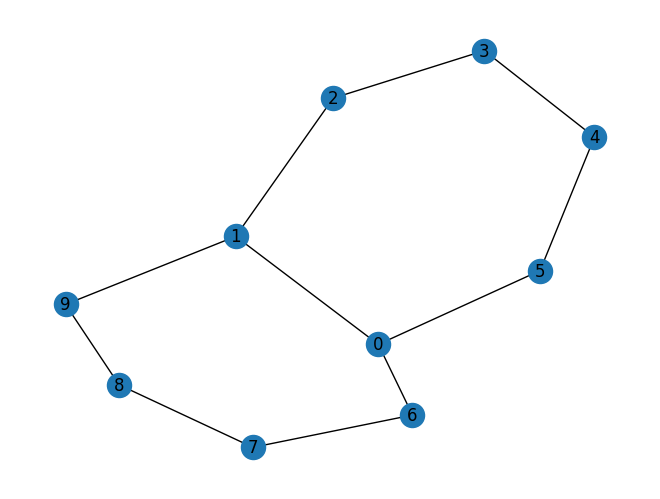

In [174]:
G_1 = nx.Graph()
G_1.add_nodes_from([0,1,2,3,4,5,6,7,8,9])
G_1.add_edges_from([(0,1),(1,2),(2,3), (3,4), (4,5), (5,0), (0,6), (6,7), (7,8), (8,9), (9,1)])
nx.draw(G_1, with_labels=True)

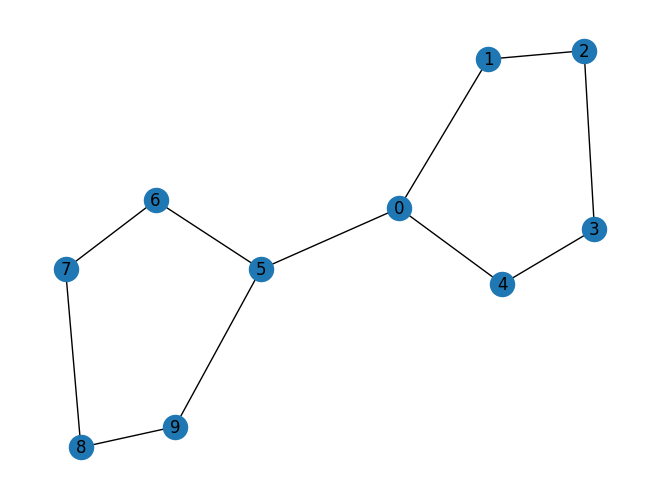

In [179]:
G_2 = nx.Graph()
G_2.add_nodes_from([0,1,2,3,4,5,6,7,8,9])
G_2.add_edges_from([(0,1),(1,2),(2,3), (3,4), (4,0), (0,5), (5,6), (6,7), (7,8), (8,9), (9,5)])
nx.draw(G_2, with_labels=True)

In [180]:
G = [G_1, G_2]

adj = sp.block_diag([nx.adjacency_matrix(G) for G in G])
x = np.ones((adj.shape[0],1))
idx = []

for i, G in enumerate(G):
    idx += [i]*G.number_of_nodes()

adj = sparse_mx_to_torch_sparse_tensor(adj).to(device)
x = torch.FloatTensor(x).to(device)
idx = torch.LongTensor(idx).to(device)

neighbor_aggr = readout = 'sum'

model = GNN(1, hidden_dim, output_dim, neighbor_aggr, readout, dropout)

print(model(x, adj, idx))

tensor([[21.8561, -3.9065, -5.8997, -3.5650],
        [21.8561, -3.9065, -5.8997, -3.5650]], grad_fn=<AddmmBackward0>)
